In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt

In [2]:
def cal_camera(nx, ny):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #plt.imshow(img)
    return objpoints, imgpoints

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
def color_combined(undistorted):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

In [5]:
def warper(combined_binary, src, dst):
    # Compute and apply perpective transform
    img_size = (combined_binary.shape[1], combined_binary.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)  # keep same size as input image
    return warped


def fit_polynomial(binary_warped, leftx, lefty, rightx, righty):
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fit, right_fit, left_fitx, right_fitx, ploty

In [6]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

In [7]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit_new, right_fit_new, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fit_new, right_fit_new, left_fitx, right_fitx, ploty

In [8]:
def measure_curvature_real(poly_lines, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    #15 meters per pixel was used vs 30 per a mentor response.
    ym_per_pix = 15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, poly_lines.shape[0]-1, poly_lines.shape[0])
    
    left_fitx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    right_fitx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [9]:
def process_image(img, objpoints, imgpoints, out_name, left_fit, right_fit):
    #Parameter definitions
    #I obtained these exact values from a help section response. My original values were similar but these performed better. 
    src = np.float32([[568, 468], [715, 468], [1040, 680], [270,680]])
    dst = np.float32([[200,0], [1000, 0], [1000, 680], [200, 680]])
    
    #Get the undistorted image
    undistorted = cal_undistort(img, objpoints, imgpoints)
    #Get the combined_binary image
    color_binary, combined_binary = color_combined(undistorted)
    #Warp the combined_binary image so that the image is a bird's eye view
    binary_warped = warper(combined_binary, src, dst)
    
    #if first frame use windowing otherwise use search_around_poly
    if left_fit.size == 0 or right_fit.size == 0:
        poly_lines, left_fit_new, right_fit_new, left_fitx, right_fitx, ploty = find_lane_pixels(binary_warped)
    else:
        poly_lines, left_fit_new, right_fit_new, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, left_fit, right_fit)
    
    
    left_curverad, right_curverad = measure_curvature_real(poly_lines, left_fitx, right_fitx)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    out_text = ""+str(left_curverad)+"m, "+str(right_curverad)+"m"
    result_text = cv2.putText(np.copy(result), out_text, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
    
    #Basic idea came from a mentor suggestion. 
    position = (left_fitx[img.shape[0]-1] + right_fitx[img.shape[0]-1]) / 2
    offset = abs(img.shape[0]-1 / 2 - position)
    real_offset = offset * (3.7/700)
    
    if (position > (img.shape[0]/2)):
        offset_text = "Vehicle is %.2fm left of center" %real_offset
    else:
        offset_text = "Vehicle is %.2fm right of center" %real_offset
    
    result_text = cv2.putText(result_text, offset_text, (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
    
    if (out_name != ""):
        mpimg.imsave("output_images/Undistorted_images/"+out_name+"_undistorted.jpg", undistorted)
        mpimg.imsave("output_images/Color_binary_images/"+out_name+"_color_binary.jpg", color_binary, cmap='gray')
        mpimg.imsave("output_images/Combined_binary_images/"+out_name+"_combined_binary.jpg", combined_binary, cmap='gray')
        mpimg.imsave("output_images/Birds_eye_images/"+out_name+"_birds_eye.jpg", binary_warped, cmap='gray')
        mpimg.imsave("output_images/Poly_lines_images/"+out_name+"_poly_lines.jpg", poly_lines)
    
    return result_text, left_fit_new, right_fit_new

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [23:02<00:01,  1.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 20min 33s, sys: 15.6 s, total: 20min 49s
Wall time: 23min 5s


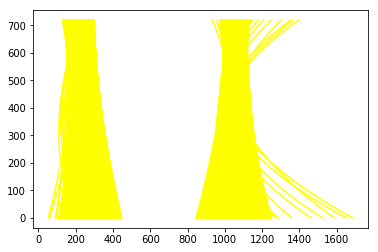

In [10]:
nx = 9
ny = 6
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

#Calibrate the camera
objpoints,imgpoints = cal_camera(nx, ny)

calibration_image = mpimg.imread("camera_cal/calibration1.jpg")
undist_calibration = cal_undistort(calibration_image, objpoints, imgpoints)
mpimg.imsave("output_images/undistorted_calibration1.jpg", undist_calibration)

left_fit = np.array([])
right_fit = np.array([])
out_name = ""
    
def pipeline(image):
    global left_fit
    global right_fit
    result, left_fit_new, right_fit_new = process_image(image, objpoints, imgpoints, out_name, left_fit, right_fit)
    left_fit = left_fit_new
    right_fit = right_fit_new
    return result


#Run on test images
images = glob.glob('test_images/*.jpg')

for img_name in images:
    left_fit = np.array([])
    right_fit = np.array([])
    out_name = img_name[12:-4]
    img = mpimg.imread(img_name)
    result = pipeline(img)
    mpimg.imsave("output_images/Result_images/"+out_name+"_result.jpg", result)


#Run on test video
out_name = ""
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(video_output, audio=False)




In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))